In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import perturbseq as perturb
import sc_eVIP

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

counts=20000

FIGS=DATA+'/2020-09-15_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2020-09-15_Figures/


In [3]:
adata=sc.read(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.regress_out_vbc.analysis.1000cells.new_format.h5ad',cache=False)
adata

Only considering the two last: ['.new_format', '.h5ad'].
Only considering the two last: ['.new_format', '.h5ad'].


AnnData object with n_obs × n_vars = 90262 × 1145 
    obs: 'batch', 'known', 'n_counts', 'n_genes', 'percent_mito', 'n_counts_downsampled', 'n_counts_original', 'vbc.counts', 'batch_num4', 'batch_num7', 'batch_num11', 'batch_num8', 'batch_num13', 'batch_num23', 'batch_num9', 'batch_num2', 'batch_num24', 'batch_num10', 'batch_num12', 'batch_num16', 'batch_num20', 'batch_num18', 'batch_num25', 'batch_num31', 'batch_num28', 'batch_num5', 'batch_num14', 'batch_num15', 'batch_num29', 'batch_num3', 'batch_num6', 'batch_num22', 'batch_num26', 'batch_num17', 'batch_num27', 'batch_num1', 'batch_num19', 'batch_num21', 'batch_num0', 'batch_num30', 'louvain', 'G1.S', 'G2.M', 'M', 'M.G1', 'S', 'phase.multi', 'guide', 'guide.compact', 'A146P', 'K117R', 'Y166H', 'K169K', 'K178K', 'T50P', 'A146V', 'L52F', 'K176Q', 'A155G', 'G60D', 'T158T', 'K88K', 'D119G', 'L159S', 'G13V', 'Q61P', 'D33E', 'S136N', 'K179R', 'T74T', 'G60S', 'Q99E', 'G13R', 'G12D', 'R164Q', 'I36M', 'C185Y', 'I163S', 'P34R', 'G60V', 'G12

In [4]:

#collect the variants into a list
perturb.pp.get_perturbations(adata,'guide.compact')

variants=adata.uns['PS.guide.compact.list']
variants.append('unassigned')
print(variants)
print(len(variants))

['A130V', 'A146P', 'A146T', 'A146V', 'A155G', 'A59E', 'A59G', 'A59T', 'A66A', 'AG11TD', 'AG59GV', 'C118S', 'C185Y', 'D119G', 'D173D', 'D30D', 'D33E', 'D57N', 'E31K', 'E63K', 'F141L', 'G12A', 'G12C', 'G12D', 'G12F', 'G12I', 'G12R', 'G12S', 'G12V', 'G12Y', 'G13C', 'G13E', 'G13R', 'G13V', 'G60D', 'G60S', 'G60V', 'G75A', 'G77A', 'I163S', 'I36M', 'K117N', 'K117R', 'K147N', 'K147T', 'K169K', 'K176Q', 'K178K', 'K179R', 'K5E', 'K88K', 'L159S', 'L19F', 'L52F', 'L79I', 'M111L', 'M170L', 'N26Y', 'P110S', 'P34L', 'P34R', 'Q22H', 'Q22K', 'Q25H', 'Q61A', 'Q61H', 'Q61K', 'Q61L', 'Q61P', 'Q61R', 'Q99E', 'R135T', 'R149K', 'R164Q', 'R41K', 'R68S', 'S136N', 'S17S', 'T127T', 'T144P', 'T144T', 'T158A', 'T158T', 'T20M', 'T20R', 'T20T', 'T50I', 'T50P', 'T50T', 'T58I', 'T74A', 'T74T', 'V112I', 'V14I', 'V14L', 'V8V', 'WT', 'Y166H', 'unassigned']
99


In [5]:
#read in the annotation file to add the clusters to it
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
anno=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.complete2.csv',sep='\t')

anno.index=anno['Variant']

anno['Position']=anno['Position'].astype('Int32')
anno['Count_pancan']=anno['Count_pancan'].astype('Int32')
anno['Count_ExAC']=anno['Count_ExAC'].astype('Int32')

syn=list(set(anno.loc[anno['control_status']=='synonymous','Variant']).intersection(set(variants)))
print(syn)
impactful=list(set(list(anno.loc[anno['control_status']=='unknown',:].index)).intersection(set(variants)))
print(len(impactful))

#cluster info
sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants.csv',header=None)
sorted_variants_df.index=sorted_variants_df[0]
anno['cluster_color']=sorted_variants_df.loc[anno.index,1]
anno.loc['unassigned','cluster_color']='pink'

['T158T', 'T20T', 'A66A', 'WT', 'T144T', 'D30D', 'V8V', 'T127T', 'D173D', 'K169K', 'K178K', 'S17S', 'T50T', 'T74T', 'K88K']
73


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [6]:
#setup subsampled datasets
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
os.system('mkdir -p '+SUBS_DIR)

subs_list=[1000,900,800,700,600,500,400,300,200,
           190,180,170,160,150,140,130,120,110,
           100,90,80,70,60,50,40,30,20,10
          ]
iters=20
for subs in subs_list:
    print(subs)
    for i in range(iters):
        #out file
        out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        
        #subsample
        my_rng=np.random.RandomState(i)
        adata_subs=perturb.pp.subsample_cells(adata,subs,'guide.compact',
                                             rng=my_rng)
        
        #write cells
        cells=pd.DataFrame({'cells':adata_subs.obs_names})
        cells.to_csv(out,index=False,header=False)
    print(out)
        

1000


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells1000.cells.csv
900


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells900.cells.csv
800


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells800.cells.csv
700


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells700.cells.csv
600


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells600.cells.csv
500
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells500.cells.csv
400
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells400.cells.csv
300
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells300.cells.csv
200
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells200.cells.csv
190
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells190.cells.

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells130.cells.csv
120
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells120.cells.csv
110
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells110.cells.csv
100
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells100.cells.csv
90
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells90.cells.csv
80
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/subsamples/subsample.iter19.cells80.cells.csv


In [8]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)


0

In [9]:
for i in range(10):
    print('========',i)
    for subs in [20,10,#50,40,30,#20,10,
        #1000,900,800,700,600,500,400,300,200,
        #         190,180,170,160,150,140,130,120,110,
        #         100,90,80,70,60,
                
    ]:
        
        print('cells',subs)
        
        out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        cell_ids=list(pd.read_csv(out).iloc[:,0])

        #get subsample
        adata_sub=adata[cell_ids,:].copy()
        
        
        #HotellingT2 ========================================
        pcs=min(20,subs-1)
        print('pcs',pcs)
        dataset=pd.DataFrame(adata_sub.obsm['X_pca'][:,:pcs],
                     index=adata_sub.obs_names,
                    columns=range(pcs))
        labels=pd.DataFrame({'label':adata_sub.obs['guide.compact']})
        labels.index=adata_sub.obs_names
        
        #compute scores and their FDRs
        scores_hotel=sc_eVIP.score.compare_groups_with_reference(dataset,
                                  labels,
                                 variants,
                                  syn,
                                 methods=['HotellingT2'],
                                 n_bootstrap_controls=0)
        
        #correlation ==========================================
        dataset=pd.DataFrame(adata_sub.X,index=adata_sub.obs_names,
                    columns=adata_sub.var_names)

        scores_corr=sc_eVIP.score.compare_groups_with_reference(dataset,
                                          labels,
                                         variants,
                                          syn,
                                         methods=['avg.pearson'],
                                         n_bootstrap_controls=0) 
        scores_all=scores_corr
        
        for c in scores_hotel.columns:
            if c not in scores_all.columns:
                scores_all[c]=scores_hotel.loc[scores_all.index,c]

        out=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_all.to_csv(out)

======== 0
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %======== 1
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %======== 2
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %======== 3
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %Found 15/15 controls
99 %======== 4
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %======== 5
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %======== 6
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %======== 7
cells 20
pcs 19
Found 15/15 control

In [2]:
#get the impactful as the ones called at 1000 cells
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)




NameError: name 'DATA' is not defined

In [34]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)

def get_precision_recall(score_df,colname,trues,fdr):
    
    sigs=list(score_df.loc[score_df[colname]<=fdr,:].index)
    print('true',len(trues))
    recall_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(list(trues))
    if len(sigs)==0:
        precision_here=0.0
    else:
        precision_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(sigs)
    return(precision_here,recall_here)

res={}
outs={}
methods=['HotellingT2','avg.pearson']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP','cluster'])


fdr_total=0.05
thestat='.q'
for i in range(10):
    print(i)
    outs[i]={}
    for subs in [50,40,30,#20,10,
        1000,900,800,700,600,500,400,300,200,
                 190,180,170,160,150,140,130,120,110,
                 100,90,80,70,60,
    ]:
        outs[i][subs]={}
        
        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2=pd.read_csv(out2,index_col=0)
        print(scores_real2.head())

        for fdr in [fdr_total]:

            for method in methods:
                
                #all variants
                #============
                #get impactful variants
                impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                print(method,fdr,'impactful',len(impactful))
                
                pre,rec=get_precision_recall(scores_real2,
                                             method+thestat,
                                             impactful,fdr)
                res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':'all',
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                res[method]=pd.concat([res[method],res_here])
                
                
                #now, go through each cluster of variants and compute (vs original ctrls)
                for cl in ['#138D75', '#BB8FCE', 'gold', 'red']:
                    print(method,cl,subs)
                    cl_variants=list(anno.loc[anno['cluster_color']==cl,:].index)
                    #print('cl variants',len(cl_variants))
                    #print('ctrls',len(ctrls))
                    cl_variants_sig=list(set(cl_variants).intersection(set(impactful)))
                    variants_here=list(set(cl_variants).union(set(ctrls)))
                    print('variants here',len(variants_here))
                    pre,rec=get_precision_recall(scores_real2.loc[variants_here,:],
                                             method+thestat,
                                             cl_variants_sig,
                                                 fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':cl,
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)+'.cl'+cl])
                    print('---')
                    #print('sigs',len(cl_variants_sig))
                    #print('cl',len(cl_variants))
                    #print('ctrls',len(ctrls))
                    #print('fp',1-pre)
                    #print('====')
                    res[method]=pd.concat([res[method],res_here])
                
                

0
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.061694                 1.043990                  1.079397   
K169K          0.890064                 0.860577                  0.919551   
R135T          0.825015                 0.795301                  0.854730   
G12R           1.311229                 1.281389                  1.341068   
Q61R           1.295541                 1.264393                  1.326689   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010         98.340855                83.441397   
K169K       0.421301         42.361630                37.055383   
R135T       0.640212         29.355108                26.146246   
G12R        0.000010        476.980696               437.060317   
Q61R        0.000010        807.954504               725.607455   

       HotellingT2.ci.0.95.high  HotellingT2.q  
G60V                 113.240313       0.000010  
K169K                 47.667

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



12
---
HotellingT2 #BB8FCE 110
variants here 34
true 3
---
HotellingT2 gold 110
variants here 41
true 10
---
HotellingT2 red 110
variants here 62
true 31
---
avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 110
variants here 49
true 12
---
avg.pearson #BB8FCE 110
variants here 40
true 3
---
avg.pearson gold 110
variants here 47
true 10
---
avg.pearson red 110
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.115465                 1.102584                  1.128347   
K169K          0.743396                 0.717961                  0.768830   
R135T          0.717190                 0.697843                  0.736537   
G12R           1.457406                 1.432323                  1.482489   
Q61R           1.451101                 1.423849                  1.478354   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        167.294559               151.667671 

variants here 43
true 12
---
HotellingT2 #BB8FCE 600
variants here 34
true 3
---
HotellingT2 gold 600
variants here 41
true 10
---
HotellingT2 red 600
variants here 62
true 31
---
avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 600
variants here 49
true 12
---
avg.pearson #BB8FCE 600
variants here 40
true 3
---
avg.pearson gold 600
variants here 47
true 10
---
avg.pearson red 600
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.163855                 1.150335                  1.177374   
K169K          0.337423                 0.313374                  0.361472   
R135T          0.334534                 0.315649                  0.353419   
G12R           1.763288                 1.755920                  1.770656   
Q61R           1.759562                 1.748431                  1.770693   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        601.443182    

HotellingT2 red 150
variants here 62
true 31
---
avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 150
variants here 49
true 12
---
avg.pearson #BB8FCE 150
variants here 40
true 3
---
avg.pearson gold 150
variants here 47
true 10
---
avg.pearson red 150
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.053706                 1.022966                  1.084447   
K169K          0.663266                 0.636124                  0.690407   
R135T          0.662092                 0.633358                  0.690825   
G12R           1.524593                 1.503744                  1.545442   
Q61R           1.544734                 1.519724                  1.569744   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V         0.00001        204.340050               182.514920   
K169K        0.47108         32.622241                27.531822   
R135T        0.47108         33.560721 

true 3
---
HotellingT2 gold 900
variants here 41
true 10
---
HotellingT2 red 900
variants here 62
true 31
---
avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 900
variants here 49
true 12
---
avg.pearson #BB8FCE 900
variants here 40
true 3
---
avg.pearson gold 900
variants here 47
true 10
---
avg.pearson red 900
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.237535                 1.222251                  1.252819   
K169K          0.247281                 0.233219                  0.261344   
R135T          0.242169                 0.225340                  0.258999   
G12R           1.811891                 1.803093                  1.820689   
Q61R           1.812043                 1.800982                  1.823104   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        915.946593               876.568225   
K169K       0.667674         31.755597       

true 31
---
avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 160
variants here 49
true 12
---
avg.pearson #BB8FCE 160
variants here 40
true 3
---
avg.pearson gold 160
variants here 47
true 10
---
avg.pearson red 160
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.144663                 1.126468                  1.162857   
K169K          0.635596                 0.618172                  0.653021   
R135T          0.587257                 0.565174                  0.609339   
G12R           1.538823                 1.522574                  1.555071   
Q61R           1.555090                 1.534655                  1.575526   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        249.480661               226.788117   
K169K       0.600000         29.277483                24.170108   
R135T       0.745817         32.131234                28.408943   
G12R     

       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.235641                 1.218857                  1.252425   
K169K          0.242268                 0.227372                  0.257164   
R135T          0.240038                 0.222635                  0.257441   
G12R           1.808946                 1.796653                  1.821239   
Q61R           1.806415                 1.792434                  1.820397   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        923.733972               882.138499   
K169K       0.670330         27.880782                23.328992   
R135T       0.699199         41.588701                34.107918   
G12R        0.000010       5835.445128              5680.561729   
Q61R        0.000010       7601.591868              7429.123030   

       HotellingT2.ci.0.95.high  HotellingT2.q  
G60V                 965.329444       0.000010  
K169K                 32.43257

true 3
---
HotellingT2 gold 170
variants here 41
true 10
---
HotellingT2 red 170
variants here 62
true 31
---
avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 170
variants here 49
true 12
---
avg.pearson #BB8FCE 170
variants here 40
true 3
---
avg.pearson gold 170
variants here 47
true 10
---
avg.pearson red 170
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.112275                 1.091764                  1.132786   
K169K          0.572253                 0.559301                  0.585205   
R135T          0.573838                 0.555542                  0.592133   
G12R           1.561966                 1.543520                  1.580413   
Q61R           1.574866                 1.555448                  1.594284   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        218.448541               204.179188   
K169K       0.682874         18.820353       

true 31
---
avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 50
variants here 49
true 12
---
avg.pearson #BB8FCE 50
variants here 40
true 3
---
avg.pearson gold 50
variants here 47
true 10
---
avg.pearson red 50
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           0.996456                 0.970548                  1.022364   
K169K          0.890075                 0.864376                  0.915774   
R135T          0.849041                 0.836753                  0.861328   
G12R           1.263954                 1.236222                  1.291685   
Q61R           1.264338                 1.236422                  1.292254   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010         97.908212                82.026503   
K169K       0.640667         29.998680                25.188309   
R135T       0.740687         24.663061                21.853038   
G12R        0

avg.pearson #138D75 500
variants here 49
true 12
---
avg.pearson #BB8FCE 500
variants here 40
true 3
---
avg.pearson gold 500
variants here 47
true 10
---
avg.pearson red 500
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.123754                 1.104782                  1.142725   
K169K          0.379340                 0.363258                  0.395422   
R135T          0.366941                 0.355321                  0.378561   
G12R           1.729274                 1.720811                  1.737736   
Q61R           1.727361                 1.717754                  1.736967   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        483.016548               453.344614   
K169K       0.588745         26.016879                23.827227   
R135T       0.622222         28.121817                24.132701   
G12R        0.000010       3106.552025              3017.52

       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.049258                 1.035997                  1.062518   
K169K          0.850567                 0.824438                  0.876696   
R135T          0.848890                 0.810670                  0.887110   
G12R           1.303523                 1.284649                  1.322398   
Q61R           1.325313                 1.301685                  1.348940   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010         92.431582                83.033248   
K169K       0.595238         25.155098                20.114716   
R135T       0.628307         31.169393                26.087075   
G12R        0.000010        606.317595               536.976913   
Q61R        0.000010        565.857204               516.544317   

       HotellingT2.ci.0.95.high  HotellingT2.q  
G60V                 101.829916       0.000010  
K169K                 30.19547

avg.pearson red 700
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.196684                 1.183013                  1.210356   
K169K          0.283897                 0.271666                  0.296128   
R135T          0.281137                 0.268305                  0.293969   
G12R           1.782388                 1.771838                  1.792939   
Q61R           1.778879                 1.763804                  1.793954   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        704.594381               663.458861   
K169K       0.635912         29.670953                25.650399   
R135T       0.649541         32.908950                28.883378   
G12R        0.000010       4573.282131              4449.706119   
Q61R        0.000010       5550.973113              5424.806290   

       HotellingT2.ci.0.95.high  HotellingT2.q  
G60V                 745.72990

avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 130
variants here 49
true 12
---
avg.pearson #BB8FCE 130
variants here 40
true 3
---
avg.pearson gold 130
variants here 47
true 10
---
avg.pearson red 130
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.069304                 1.058145                  1.080463   
K169K          0.658874                 0.631007                  0.686741   
R135T          0.666108                 0.645509                  0.686707   
G12R           1.506437                 1.485371                  1.527503   
Q61R           1.506213                 1.485191                  1.527236   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        163.074316               150.597667   
K169K       0.651177         18.068811                15.004879   
R135T       0.629948         21.277118                17.276649   
G12R        0.000010 

true 3
---
HotellingT2 gold 800
variants here 41
true 10
---
HotellingT2 red 800
variants here 62
true 31
---
avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 800
variants here 49
true 12
---
avg.pearson #BB8FCE 800
variants here 40
true 3
---
avg.pearson gold 800
variants here 47
true 10
---
avg.pearson red 800
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.226085                 1.207182                  1.244987   
K169K          0.262997                 0.240462                  0.285533   
R135T          0.265981                 0.246960                  0.285001   
G12R           1.799353                 1.789065                  1.809640   
Q61R           1.794456                 1.781368                  1.807545   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        818.375290               776.295021   
K169K       0.652291         26.460919       

avg.pearson #138D75 160
variants here 49
true 12
---
avg.pearson #BB8FCE 160
variants here 40
true 3
---
avg.pearson gold 160
variants here 47
true 10
---
avg.pearson red 160
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.060638                 1.037906                  1.083369   
K169K          0.630165                 0.601943                  0.658388   
R135T          0.623559                 0.597131                  0.649987   
G12R           1.533188                 1.513872                  1.552505   
Q61R           1.543502                 1.520510                  1.566493   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        182.553143               169.147679   
K169K       0.564338         28.515438                25.169587   
R135T       0.601128         29.269579                24.987191   
G12R        0.000010       1498.299603              1447.79

avg.pearson red 70
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.069483                 1.041999                  1.096966   
K169K          0.818469                 0.785297                  0.851640   
R135T          0.815030                 0.798183                  0.831877   
G12R           1.332891                 1.317476                  1.348306   
Q61R           1.360181                 1.337354                  1.383008   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        106.840872                97.046660   
K169K       0.524991         41.165035                32.889632   
R135T       0.524991         23.635119                19.571235   
G12R        0.000010        814.438747               756.940920   
Q61R        0.000010        769.018335               724.338993   

       HotellingT2.ci.0.95.high  HotellingT2.q  
G60V                 116.635085

HotellingT2 gold 180
variants here 41
true 10
---
HotellingT2 red 180
variants here 62
true 31
---
avg.pearson 0.05 impactful 62
true 62
avg.pearson #138D75 180
variants here 49
true 12
---
avg.pearson #BB8FCE 180
variants here 40
true 3
---
avg.pearson gold 180
variants here 47
true 10
---
avg.pearson red 180
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.098199                 1.077725                  1.118674   
K169K          0.571745                 0.527800                  0.615690   
R135T          0.548789                 0.512906                  0.584673   
G12R           1.554871                 1.527355                  1.582387   
Q61R           1.557259                 1.536514                  1.578004   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        236.729990               216.876422   
K169K       0.756044         27.015393                21

---
avg.pearson red 100
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.060919                 1.038520                  1.083318   
K169K          0.719793                 0.684657                  0.754928   
R135T          0.694726                 0.666548                  0.722903   
G12R           1.422567                 1.394191                  1.450944   
Q61R           1.432827                 1.410540                  1.455113   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        143.935201               130.223230   
K169K       0.710314         27.060484                20.445761   
R135T       0.773626         28.967463                23.733400   
G12R        0.000010        647.057208               612.262137   
Q61R        0.000010        798.047382               764.672444   

       HotellingT2.ci.0.95.high  HotellingT2.q  
G60V                 157.6

true 3
---
avg.pearson gold 700
variants here 47
true 10
---
avg.pearson red 700
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.193942                 1.178929                  1.208954   
K169K          0.303320                 0.292213                  0.314428   
R135T          0.286279                 0.268301                  0.304257   
G12R           1.786568                 1.776591                  1.796546   
Q61R           1.780020                 1.766443                  1.793597   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        684.197387               648.736828   
K169K       0.619994         33.023202                27.711165   
R135T       0.672222         36.735207                30.885351   
G12R        0.000010       4502.134315              4394.799717   
Q61R        0.000010       5516.449655              5404.912223   

       HotellingT2

variants here 40
true 3
---
avg.pearson gold 120
variants here 47
true 10
---
avg.pearson red 120
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.059076                 1.038327                  1.079825   
K169K          0.709522                 0.686171                  0.732874   
R135T          0.690392                 0.672208                  0.708577   
G12R           1.461381                 1.437219                  1.485543   
Q61R           1.467103                 1.436568                  1.497638   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        167.298787               146.713554   
K169K       0.621574         29.080494                24.611823   
R135T       0.676048         27.037079                21.760522   
G12R        0.000010        930.607194               866.063430   
Q61R        0.000010        946.055202               898.571190   

 

avg.pearson #BB8FCE 700
variants here 40
true 3
---
avg.pearson gold 700
variants here 47
true 10
---
avg.pearson red 700
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.216999                 1.200933                  1.233066   
K169K          0.284550                 0.268186                  0.300913   
R135T          0.283064                 0.263878                  0.302250   
G12R           1.783938                 1.772235                  1.795640   
Q61R           1.779586                 1.765965                  1.793208   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        728.398751               681.101490   
K169K       0.634229         24.638444                20.616165   
R135T       0.643684         38.780478                31.654128   
G12R        0.000010       4819.791539              4675.236587   
Q61R        0.000010       5972.591643       

avg.pearson #BB8FCE 120
variants here 40
true 3
---
avg.pearson gold 120
variants here 47
true 10
---
avg.pearson red 120
variants here 68
true 31
---
       avg.pearson.mean  avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.high  \
G60V           1.056862                 1.033557                  1.080166   
K169K          0.703830                 0.673518                  0.734142   
R135T          0.660584                 0.628672                  0.692496   
G12R           1.472549                 1.445187                  1.499911   
Q61R           1.494755                 1.467573                  1.521937   

       avg.pearson.q  HotellingT2.mean  HotellingT2.ci.0.95.low  \
G60V        0.000010        156.479377               139.858841   
K169K       0.586037         28.475011                24.769249   
R135T       0.687933         22.988387                19.806424   
G12R        0.000010        894.053550               841.111420   
Q61R        0.000010       1111.532915       

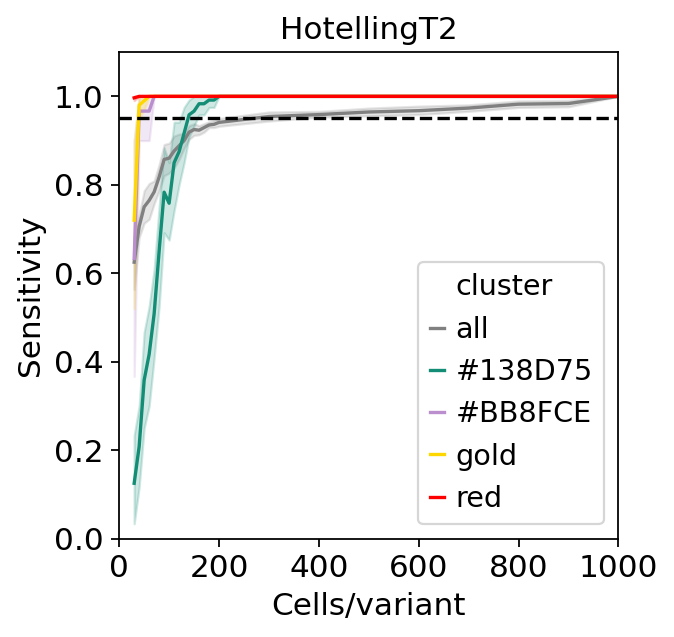

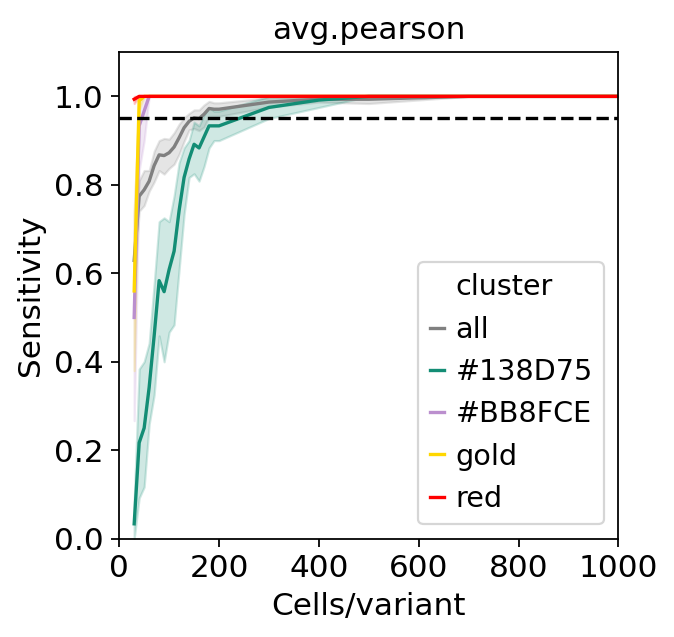

In [35]:
#how to make lines with error bars
method='HotellingT2'

palette={}
for i in ['#138D75', '#BB8FCE', 'black', 'gold', 'red']:
    palette[i]=i
palette['all']='gray'
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette=palette,
    ci=95,
)
plt.ylim(0,1.1)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette=palette,
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

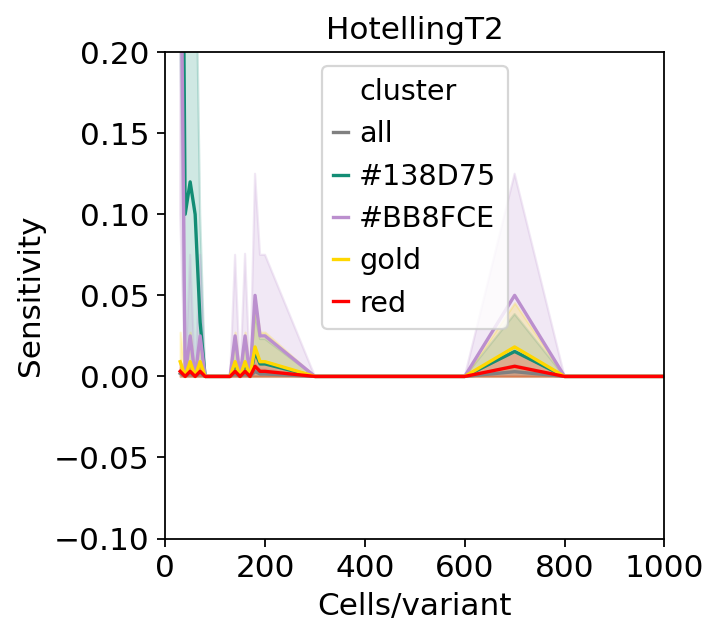

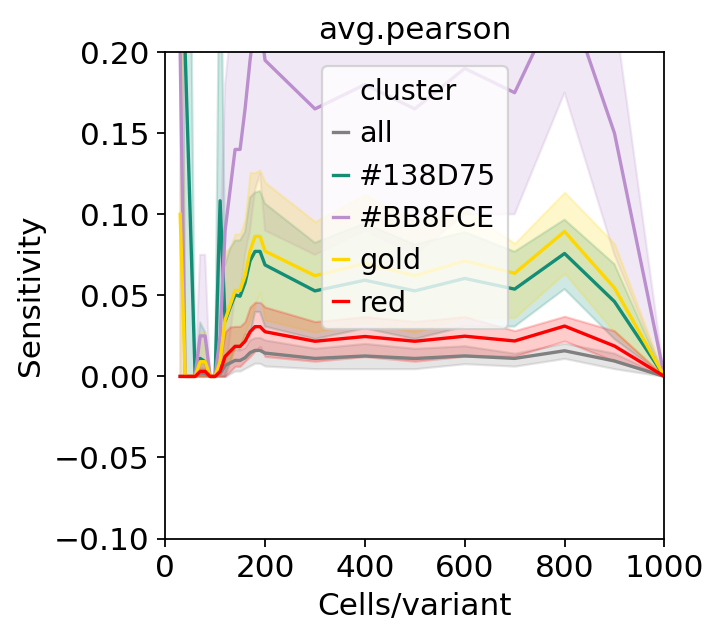

In [37]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette=palette,
    ci=95,
)
plt.ylim(-0.1,0.2)
plt.xlim(0,1000)
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()


#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette=palette,
    ci=95,
)
plt.ylim(-0.1,0.2)
plt.grid(False)
plt.xlim(0,1000)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [31]:
res[method]




,FDR,FP,cells,cluster,recall
500.0.05.0,0.05,0.000000,500,all,0.951613
500.0.05.0.cl#138D75,0.05,0.000000,500,#138D75,1.000000
500.0.05.0.cl#BB8FCE,0.05,0.000000,500,#BB8FCE,1.000000
500.0.05.0.clgold,0.05,0.000000,500,gold,1.000000
500.0.05.0.clred,0.05,0.000000,500,red,1.000000
100.0.05.0,0.05,0.000000,100,all,0.838710
100.0.05.0.cl#138D75,0.05,0.000000,100,#138D75,0.500000
100.0.05.0.cl#BB8FCE,0.05,0.000000,100,#BB8FCE,1.000000
100.0.05.0.clgold,0.05,0.000000,100,gold,1.000000
100.0.05.0.clred,0.05,0.000000,100,red,1.000000


In [38]:
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter1.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)
anno=anno.loc[variants,:]
scores.head()

,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,avg.pearson.q,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,HotellingT2.q
G60V,1.253456,1.237229,1.269683,0.000010,1150.306599,1095.869517,1204.743680,0.000010
K169K,0.212832,0.196634,0.229029,0.652089,36.598795,29.903929,43.293662,0.562637
R135T,0.208239,0.191273,0.225206,0.670122,49.667739,41.790030,57.545448,0.334641
G12R,1.826844,1.815557,1.838132,0.000010,6506.519197,6277.833133,6735.205261,0.000010
Q61R,1.826356,1.812848,1.839864,0.000010,9063.812576,8729.790204,9397.834949,0.000010


thresh 79.90180580523186


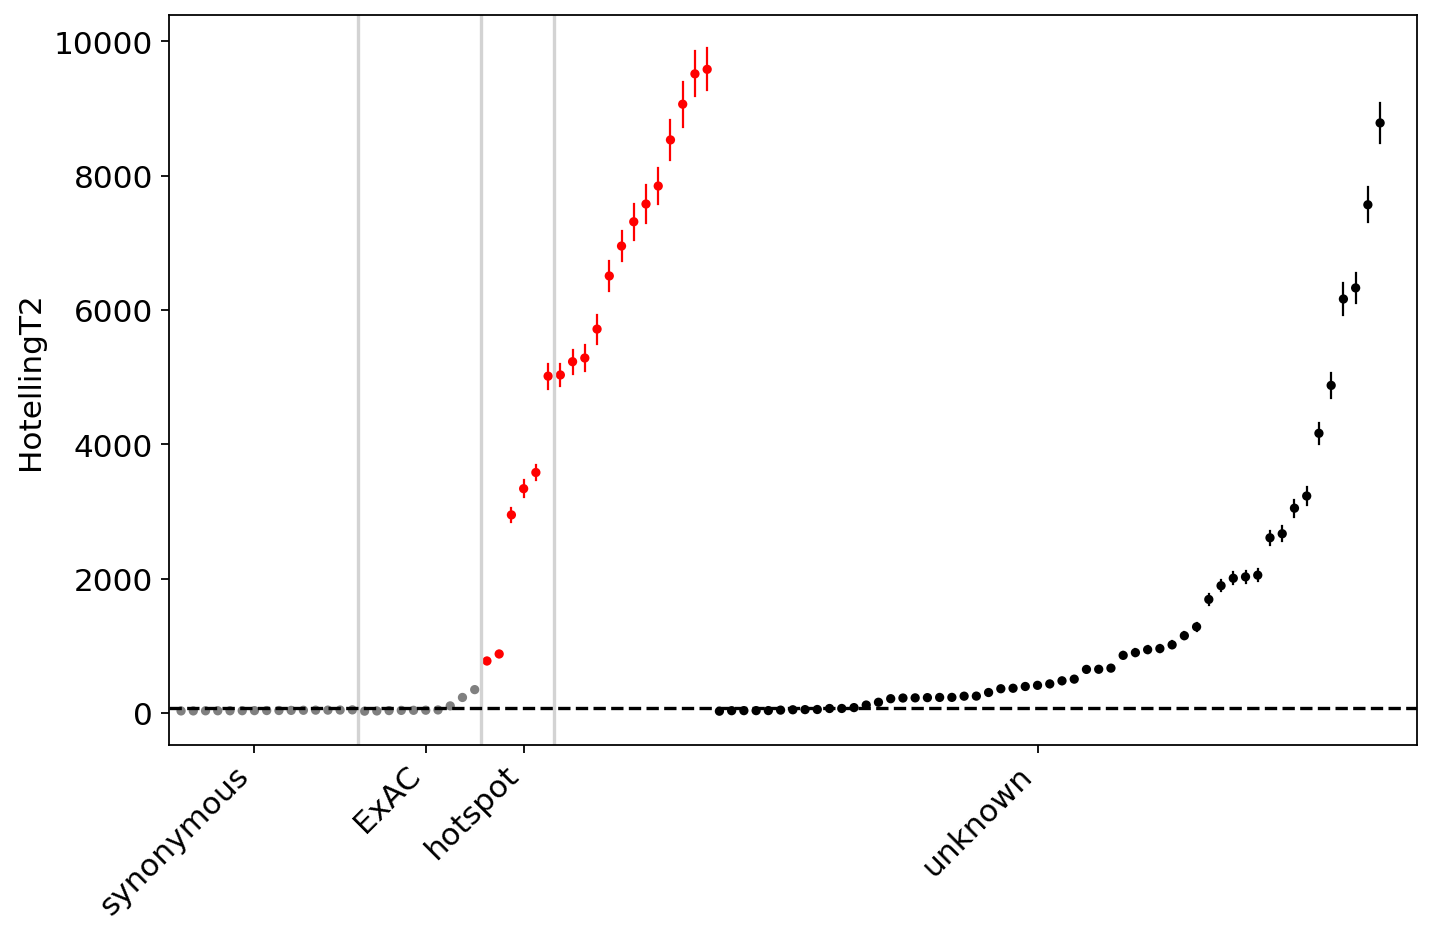

thresh 0.3713985644827001


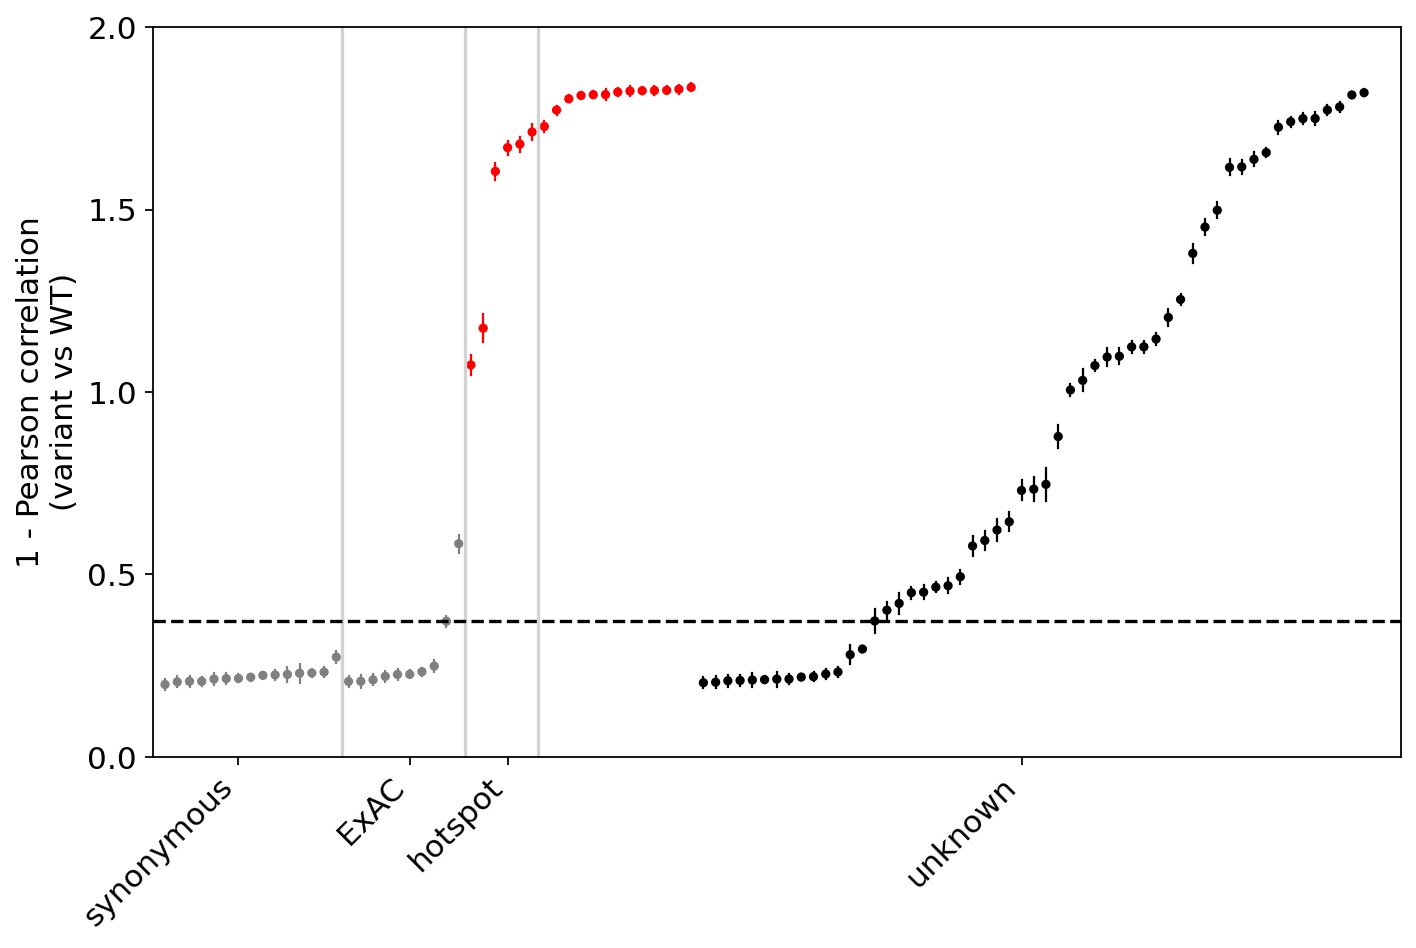

In [39]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,scorename,signame,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[signame]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=False)
    score_thresh_value=float(list(fdr_passed[scorename])[0])
    return(score_thresh_value)
    
methods=['HotellingT2','avg.pearson']
for method in methods:
    anno[method+'.mean']=scores.loc[anno.index,method+'.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.sort_values(by=['control_status2',method+'.mean'],ascending=True)

    w=10
    h=6
    fig,plots=plt.subplots(1)
    fig.set_size_inches(w,h)
    plot_with_errorbars(list(anno.index),
                        scores.loc[anno.index,method+'.mean'],
                        #scores.loc[anno.index,method],
                       scores.loc[anno.index,method+'.ci.0.95.low'],
                       scores.loc[anno.index,method+'.ci.0.95.high'],
                        plots=plots,
                        flip_axes=False,
                        color_lines=list(anno.loc[:,'text_color']),

                        s=10,
                       c=list(anno.loc[:,'text_color']))
    plots.axvline(x=14.5,color='lightgray')
    plots.axvline(x=24.5,color='lightgray')
    plots.axvline(x=30.5,color='lightgray')
    if method=='avg.pearson':
        plots.set_ylabel('1 - Pearson correlation\n(variant vs WT)')
        plots.set_ylim(0,1.5)
        plots.set_yticks([0,0.5,1.0,1.5,2.0])
    if method=='HotellingT2':
        plots.set_ylabel('HotellingT2')
        #plots.set_ylim(0,1.5)
        #plots.set_yticks([0,0.5,1.0,1.5])
    plots.set_xticklabels([])
    plots.set_xlim(-1,101)
    plots.set_xticks([6,20,28,70])
    plots.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,
                         ha='right')

    #figure out FDR line
    thresh=get_threshold_at_FDR(scores,scorename=method+'.mean',
                                signame=method+'.q',
                                FDR=0.01)
    print('thresh',thresh)
    plt.axhline(y=thresh,color='black',linestyle='--')
    plt.show()

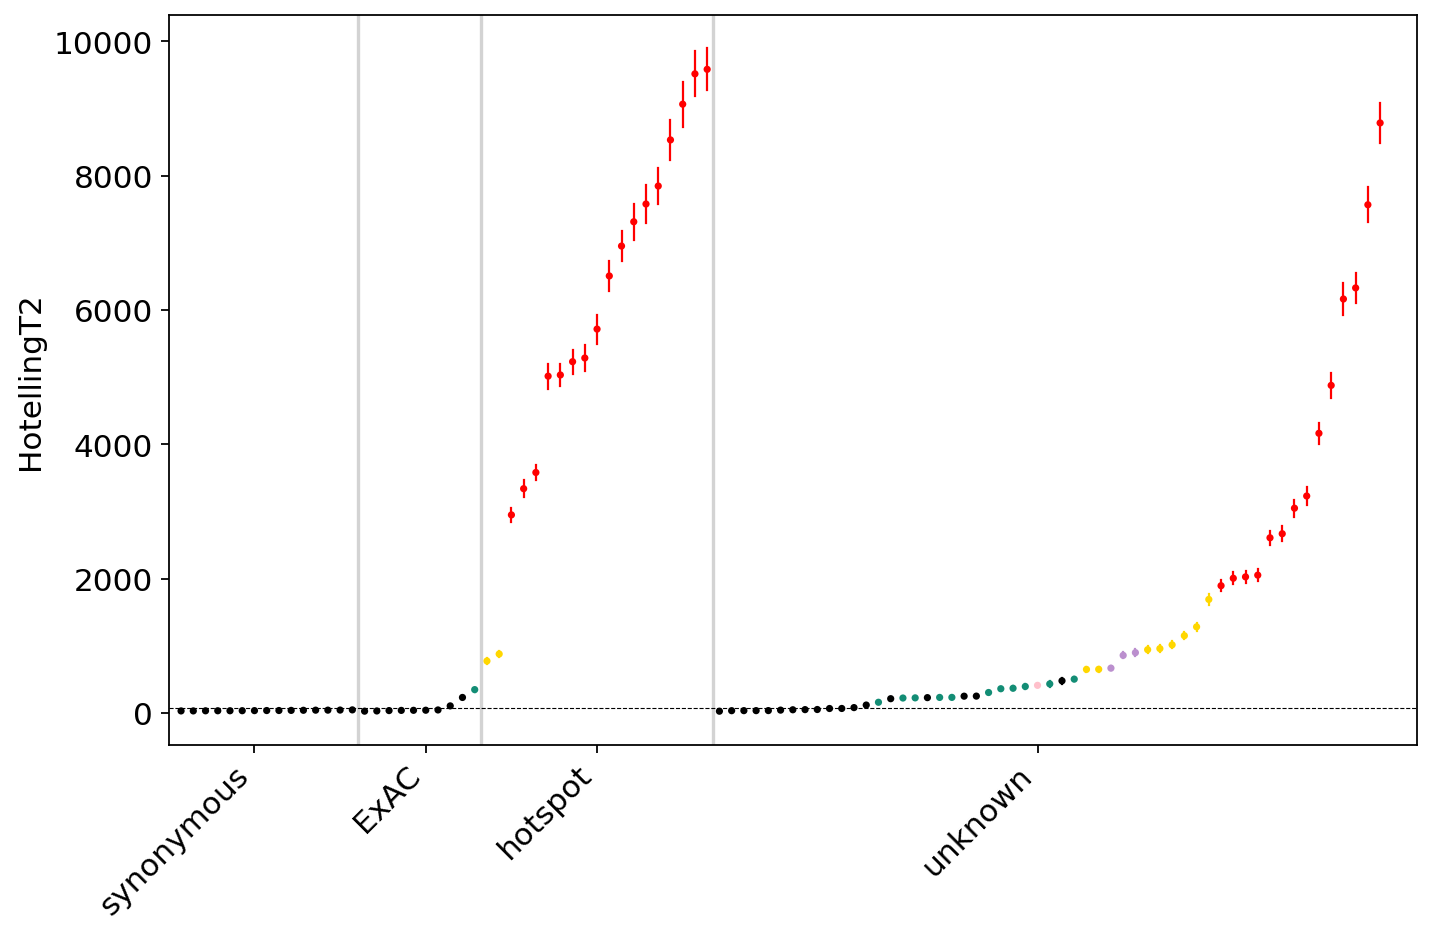

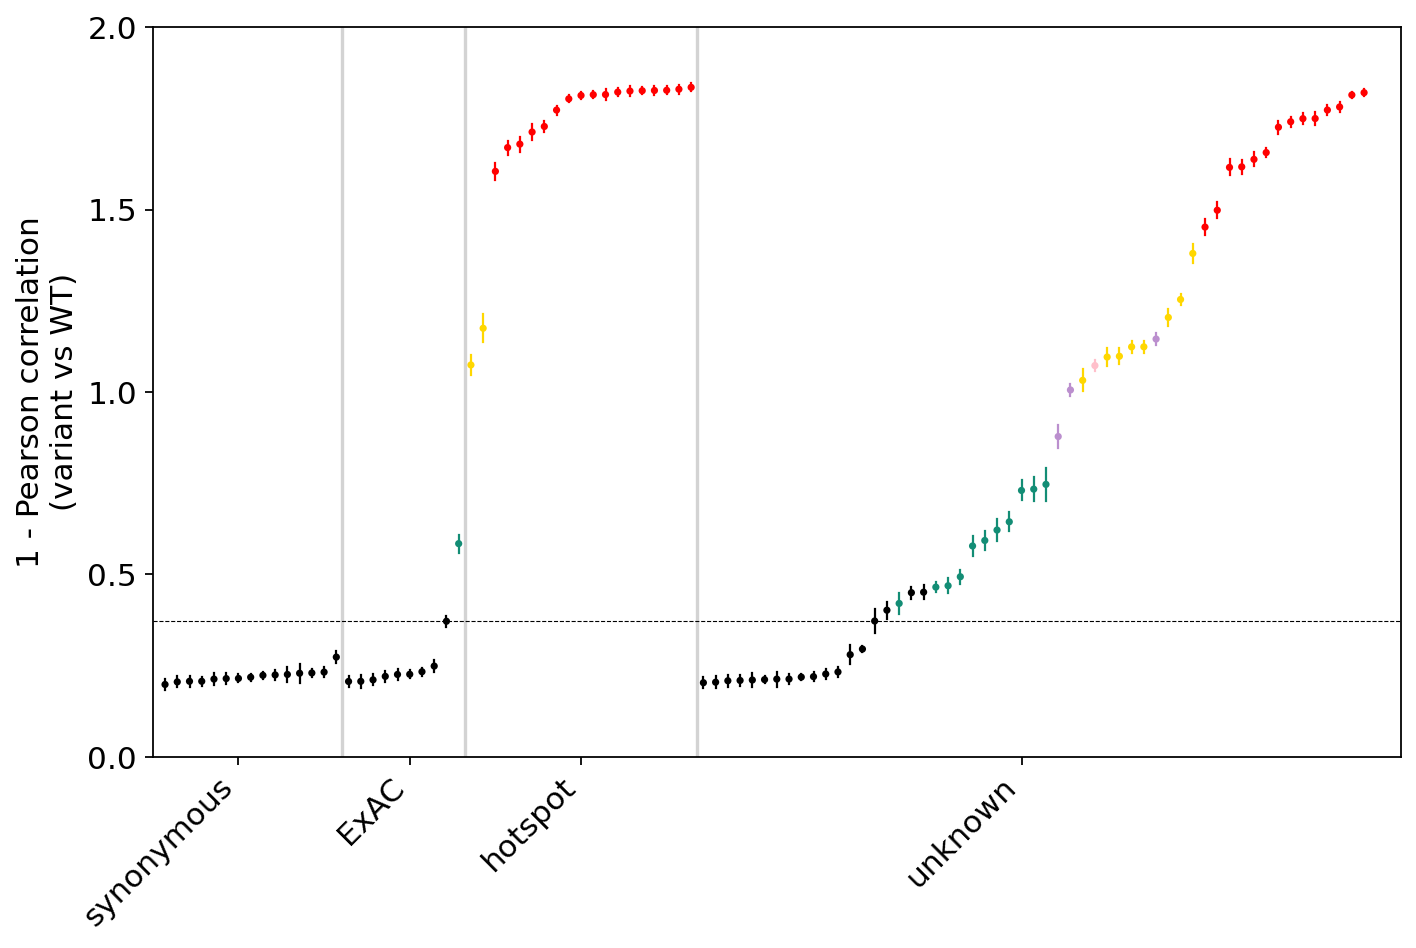

In [42]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,scorename,signame,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[signame]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=False)
    score_thresh_value=float(list(fdr_passed[scorename])[0])
    return(score_thresh_value)
    
methods=['HotellingT2','avg.pearson']
for method in methods:
    anno[method+'.mean']=scores.loc[anno.index,method+'.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.loc[variants,:]
    anno=anno.sort_values(by=['control_status2',method+'.mean'],ascending=True)

    w=10
    h=6
    fig,plots=plt.subplots(1)
    fig.set_size_inches(w,h)
    plot_with_errorbars(list(anno.index),
                        scores.loc[anno.index,method+'.mean'],
                       scores.loc[anno.index,method+'.ci.0.95.low'],
                       scores.loc[anno.index,method+'.ci.0.95.high'],
                        plots=plots,
                        flip_axes=False,
                        color_lines=list(anno.loc[anno.index,'cluster_color']),

                        s=5,
                       c=list(anno.loc[anno.index,'cluster_color']))
    plots.axvline(x=14.5,color='lightgray')
    plots.axvline(x=24.5,color='lightgray')
    plots.axvline(x=43.5,color='lightgray')
    if method=='avg.pearson':
        plots.set_ylabel('1 - Pearson correlation\n(variant vs WT)')
        plots.set_ylim(0,2)
        plots.set_yticks([0,0.5,1.0,1.5,2])
    if method=='HotellingT2':
        plots.set_ylabel('HotellingT2')
        #plots.set_ylim(0,1.5)
        #plots.set_yticks([0,0.5,1.0,1.5])
    plots.set_xticklabels([])
    plots.set_xlim(-1,101)
    plots.set_xticks([6,20,34,70])
    plots.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,
                         ha='right')

    #figure out FDR line
    thresh=get_threshold_at_FDR(scores,scorename=method+'.mean',
                                signame=method+'.q',
                                FDR=0.01)
    plt.axhline(y=thresh,color='black',linestyle='--',linewidth=0.5)
    plt.show()

In [7]:
def compare_2_groups_df(cellsxvalues,
                     group1_cells,group2_cells,
                     method):
    
    g1_data=cellsxvalues.loc[group1_cells,:]
    g2_data=cellsxvalues.loc[group2_cells,:]

    #T2 Hotelling
    #============
    if method=='HotellingT2':
        import spm1d
        
        T2=spm1d.stats.hotellings2(g1_data,g2_data)
        value=T2.z #the T2 statistic

    #bulk analysis
    #==============
    if 'avg' in method:
        #get the averaged data
        g1_bulk=np.mean(np.array(g1_data),axis=0)
        g2_bulk=np.mean(np.array(g2_data),axis=0)

    if method=='avg.pearson':
        from scipy.stats import pearsonr
        value=1-pearsonr(g1_bulk,g2_bulk)[0]

    if method=='avg.spearman':
        from scipy.stats import spearmanr
        value=1-spearmanr(g1_bulk,g2_bulk)[0]
        
    if method=='avg.L1':
        from scipy.spatial.distance import cityblock
        value=cityblock(g1_bulk,g2_bulk)

    return(value)

def compare_two_groups(adata_here,
                       grouping_variable,
                       g1,g2,
                       methods=['HotellingT2','avg.pearson','avg.spearman','avg.L1'],
                       num_pcs_hotelling=20):
    
    #convert the adata to a data frame here
    data_here=pd.DataFrame(adata_here.X,
                          columns=adata_here.var_names,
                         index=adata_here.obs_names)
    if 'HotellingT2' in methods:
        data_here_pca=pd.DataFrame(adata_here.obsm['X_pca'][:,:num_pcs_hotelling],
                             index=adata_here.obs_names)
    
    g1_cells=adata_here.obs_names[adata_here.obs[grouping_variable]==g1]
    g2_cells=adata_here.obs_names[adata_here.obs[grouping_variable]==g2]
    
    comparison_name=g1+'.VS.'+g2
    cols=['group1','group2']
    for m in methods:
        cols.append(m)
    df_comparison=pd.DataFrame(0,columns=cols,index=[comparison_name])
    
    for method in methods:
        if method=='HotellingT2':
            v=compare_2_groups_df(data_here_pca,g1_cells,g2_cells,method)
        else:
            v=compare_2_groups_df(data_here,g1_cells,g2_cells,method)
        df_comparison.loc[comparison_name,method]=v
        df_comparison.loc[comparison_name,'group1']=g1
        df_comparison.loc[comparison_name,'group2']=g2
    df_comparison=df_comparison.reset_index(drop=True)
        
    return(df_comparison)

def get_conf_interval(data,ci_size=0.95):
    from scipy.stats import t, sem

    #create 95% confidence interval for population mean weight
    ci1,ci2=t.interval(alpha=ci_size, df=len(data)-1, 
               loc=np.mean(data), scale=sem(data)) 
    return(ci1,ci2)

#convert our scores to empirical p-values
def empirical_pvalues(values_df,empirical_dist):
    
    values=list(values_df)
    from scipy import stats
    ps=[]
    for i in range(len(values)):
        p=(100.0-stats.percentileofscore(empirical_dist,values[i]))/100.0
        ps.append(p)
    return(np.array(ps))

def qvalue(ps,mini=1e-5):
    thresh=0.5
    total=ps.shape[0]
    above=(ps>thresh).sum()
    exp_fp=int(above*(1.0/thresh))
    pi_0=1.0*exp_fp/total

    qs=[]
    for p_idx in range(ps.shape[0]):
        p=ps[p_idx]
        R=(ps<=p).sum()
        q=max(1.0*p*total*pi_0/R,mini)
        qs.append(q)
    return(qs)

def get_threshold_at_FDR(fdr_data,method,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data['FDR.'+method]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)

def compute_FDR(res_true,res_perm,methods,plot=False,FDR=0.01):
    
    res_true['dataset']='true data'
    res_perm['dataset']='permuted data'
    to_return={}
    
    for method in methods:
        res_combo=pd.concat([res_true.loc[:,['dataset','group2',method]],
                             res_perm.loc[:,['dataset','group2',method]]],axis=0)
        min_fdr=1.0/res_combo.shape[0]
        print('min fdr',min_fdr,res_combo.shape)
        res_combo=res_combo.sort_values(by=method,ascending=False)
        res_combo['FDR.'+method]=1
        res_combo=res_combo.reset_index(drop=True)
        for i in range(res_combo.shape[0]):
            value_here=float(list(res_combo[method])[i])
            idx=list(res_combo.index)[i]
            passed=res_combo.loc[res_combo[method]>=value_here,:]
            true_pass=np.sum(passed['dataset']=='true data')
            perm_pass=np.sum(passed['dataset']=='permuted data')
            
            true_fraction=1.0*true_pass/res_true.shape[0]
            perm_fraction=1.0*perm_pass/res_perm.shape[0]
            
            fdr_here=max(float(1.0*perm_fraction/(perm_fraction+true_fraction)),
                            float(min_fdr)) 
            res_combo.loc[idx,'FDR.'+method]=float(fdr_here)
        to_return[method]=res_combo.loc[res_combo['dataset']=='true data',:]
        to_return[method]=to_return[method].drop(columns=['dataset'])
        to_return[method].index=list(to_return[method]['group2'])
            
        if plot:
            #get even bins
            NUM_BINS=20
            max_val=np.max(res_combo[method])
            mybins=[x*max_val/NUM_BINS for x in range(NUM_BINS)]
            scores_true=res_combo.loc[res_combo['dataset']=='true data',method]
            scores_perm=res_combo.loc[res_combo['dataset']=='permuted data',method]
            plt.hist(scores_true,color='red',bins=mybins,label='Real data')
            plt.hist(scores_perm,color='black',alpha=0.5,bins=mybins,
                     weights=[len(scores_true)/len(scores_perm)]*len(scores_perm),
                    label='Permuted data')
            plt.grid(False)
            plt.xlabel(method)
            plt.ylabel('Frequency')
            #thresh_data=res_combo.loc[res_combo['FDR.'+method]<=0.01,:]
            #thresh_data=thresh_data.sort_values(by=method,ascending=True)
            #thresh=list(thresh_data[method])[0]
            thresh=get_threshold_at_FDR(res_combo.loc[res_combo['dataset']=='true data',:],method,FDR)
            thresh=int(1000*thresh)/1000
            plt.axvline(x=thresh,color='black',linestyle='dotted')
            plt.title('FDR '+str(FDR)+' threshold: '+str(thresh))
            plt.legend()
            plt.show()
            
    return(to_return)


def compare_groups_with_reference(adata_here,
                                  grouping_variable,
                                 groups,
                                 reference,
                                  controls_for_ci=[],
                                  ci_size=0.95,
                                 methods=['HotellingT2','avg.pearson'],
                                 num_pcs_hotelling=20):
    
    data_col=['group1','group2']
    for c in methods:
        data_col.append(c)
    data=pd.DataFrame(columns=data_col)
    
    #compute a matrix with scores for groups vs all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_for_ci,
                                      columns=groups)
    
    if grouping_variable not in adata_here.obs:
        print('ERROR: grouping variable "'+grouping_variable+'" is not in adata.obs')
        return 
    
    total_groups=list(set(adata_here.obs[grouping_variable]))
    if reference not in total_groups:
        print('ERROR: reference group "'+reference+'" is not in adata.obs['+grouping_variable+']')
        return 
    controls_for_ci_found=list(set(total_groups).intersection(set(controls_for_ci)))
    if len(controls_for_ci)>0:
        print('Found '+str(len(controls_for_ci_found))+'/'+str(len(controls_for_ci))+' controls for CI computation')
    
    import copy
    followup=copy.deepcopy(groups)
    for c in controls_for_ci_found:
        followup.append(c)
    followup=list(set(followup))
    counter=0
    for group in followup:
        counter+=1
        perturb.util.display_progress(counter,len(followup))
        if group not in total_groups:
            print('WARNING: group "'+group+'" is not in adata.obs['+grouping_variable+']. Skipping')
            return
        data_here=compare_two_groups(adata_here,
                               grouping_variable,
                     reference,group,
                    methods,
                    num_pcs_hotelling)
        
        if len(controls_for_ci_found)>0:
            control_scores={}
            #get scores for each control, so we can compute a confidence interval
            for ctrl in controls_for_ci_found:
                res_ctrl=compare_two_groups(adata_here,
                               grouping_variable,
                     ctrl,group,
                    methods,
                    num_pcs_hotelling)
                
                for method in methods:
                    if method not in control_scores.keys():
                        control_scores[method]=[]
                    ctrl_score_here=float(res_ctrl[method])
                    score_mat[method].loc[ctrl,group]=ctrl_score_here
                    control_scores[method].append(ctrl_score_here)
            for method in methods:
                #create confidence intervals for each method
                conf_intervals=get_conf_interval(control_scores[method],ci_size=ci_size)
                data_here[method+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
                data_here[method+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
                data_here[method+'.ci.'+str(ci_size)+'.mean']=np.mean(control_scores[method])
            
        data=pd.concat([data,data_here],axis=0,sort=True)
    data.index=list(data['group2'])
        
    #FDR control
    for method in methods:
        controls=list(set(controls_for_ci_found).difference(set([reference])))
        emp_scores=np.array(score_mat[method].loc[controls,controls]).flatten()
        emp_scores_df=pd.DataFrame({method:emp_scores})
        
        #q-values
        emp_p=empirical_pvalues(data[method],emp_scores)
        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        data[method+'.q']=qvalue(np.array(emp_p_combo))[:data[method].shape[0]]
        
        #FDR
        fdr_data2=compute_FDR(data,
                                emp_scores_df,
                                methods=[method],
                                plot=False)[method]
        data[method+'.FDR']=fdr_data2.loc[data.index,'FDR.'+method]
        
    return(data,score_mat)

In [8]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)


res={}
outs={}
methods=['HotellingT2','avg.pearson','avg.L1']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP'])
    



In [40]:
for i in range(10):
    outs[i]={}
    for subs in [50,40,30,20,10,
        1000,900,800,700,600,500,400,300,200,
                 190,180,170,160,150,140,130,120,110,
                 100,90,80,70,60,
    ]:
        outs[i][subs]={}
        print('cells',subs)
        
        out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        cell_ids=list(pd.read_csv(out).iloc[:,0])

        #get subsample
        adata_sub=adata[cell_ids,:].copy()

        #compute scores and their FDRs
        scores_real2=compare_groups_with_reference(adata_sub,
                                  grouping_variable='guide.compact',
                                 groups=variants,
                                 reference=ref,
                                  controls_for_ci=syn,
                                  ci_size=0.95,
                                 methods=['HotellingT2','avg.pearson'],
                                 num_pcs_hotelling=min(20,subs-1))[0]

        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2.to_csv(out2)

cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 50
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 40
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 30
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 20
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 10
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 1000
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 900
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 800
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 700
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 600
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 500
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 400
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 300
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 200
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 190
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 180
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 170
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 160
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 150
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 140
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 130
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 120
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 110
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 100
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
cells 90
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 80
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 70
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)
cells 60
Found 15/15 controls for CI computation
100 %

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


min fdr 0.003389830508474576 (295, 3)
min fdr 0.003389830508474576 (295, 3)


In [124]:
#get the impactful as the ones called at 1000 cells
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)

scores.head()

,HotellingT2,HotellingT2.ci.0.95.high,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.mean,avg.pearson,avg.pearson.ci.0.95.high,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.mean,group1,group2,HotellingT2.q,dataset,HotellingT2.FDR,avg.pearson.q,avg.pearson.FDR
G12F,3144.723404,3464.785590,3213.757264,3339.271427,1.625013,1.688993,1.650640,1.669816,K169K,G12F,0.000010,true data,0.003390,0.000010,0.003390
Q25H,501.883336,520.361725,436.642202,478.501963,0.180585,0.233418,0.192198,0.212808,K169K,Q25H,0.000010,true data,0.003390,0.798964,0.477671
G12V,4886.839461,5193.784121,4870.763820,5032.273970,1.789492,1.812673,1.794195,1.803434,K169K,G12V,0.000010,true data,0.003390,0.000010,0.003390
A130V,35.481710,47.973097,30.732659,39.352878,0.222556,0.236964,0.214996,0.225980,K169K,A130V,0.560911,true data,0.327435,0.626683,0.338634
Q61R,8985.817496,9397.834903,8729.790179,9063.812541,1.800905,1.839864,1.812848,1.826356,K169K,Q61R,0.000010,true data,0.003390,0.000010,0.003390


In [147]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)

def get_precision_recall(score_df,colname,trues,fdr):
    
    sigs=list(score_df.loc[score_df[colname]<=fdr,:].index)
    #print(colname)
    #print('sigs inside',len(sigs))
    #print(sigs)
    recall_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(list(trues))
    fps=list(set(sigs).difference(set(trues)))
    #print(score_df.loc[fps,:])
    #print('fps',fps)
    if len(sigs)==0:
        precision_here=0.0
    else:
        precision_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(sigs)
    return(precision_here,recall_here)

res={}
outs={}
methods=['HotellingT2','avg.pearson']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP','cluster'])

fdr_total=0.05
thestat='.q'
for i in range(10):
    print(i)
    outs[i]={}
    for subs in [50,40,30,20,10,
        1000,900,800,700,600,500,400,300,200,
                 190,180,170,160,150,140,130,120,110,
                 100,90,80,70,60,
    ]:
        outs[i][subs]={}
        
        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2=pd.read_csv(out2,index_col=0)

        for fdr in [fdr_total]:

            for method in methods:
                
                #all variants
                #============
                #get impactful variants
                impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                #print('---- all ctrls',len(ctrls))
                #print(ctrls)
                #print('all')
                pre,rec=get_precision_recall(scores_real2,
                                             method+thestat,
                                             impactful,fdr)
                res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':'all',
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                res[method]=pd.concat([res[method],res_here])
                
                thresh=get_threshold_at_FDR(scores_real2,method,statname='.q')
                #print('thresh',thresh)
                
                #now, go through each cluster of variants and compute (vs original ctrls)
                '''
                for cl in ['#138D75', '#BB8FCE', 'gold', 'red']:
                    print(method,cl,subs)
                    cl_variants=list(anno.loc[anno['cluster_color']==cl,:].index)
                    #print('cl variants',len(cl_variants))
                    #print('ctrls',len(ctrls))
                    cl_variants_sig=list(set(cl_variants).intersection(set(impactful)))
                    variants_here=list(set(cl_variants).union(set(ctrls)))
                    print('variants here',len(variants_here))
                    pre,rec=get_precision_recall(scores_real2.loc[variants_here,:],
                                             method+thestat,
                                             cl_variants_sig,
                                                 fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':cl,
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)+'.cl'+cl])
                    print('---')
                    #print('sigs',len(cl_variants_sig))
                    #print('cl',len(cl_variants))
                    #print('ctrls',len(ctrls))
                    #print('fp',1-pre)
                    #print('====')
                    res[method]=pd.concat([res[method],res_here])
                '''
                
    

0


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

1


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

2


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

3


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

4


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

5


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=Fals

6


IndexError: list index out of range

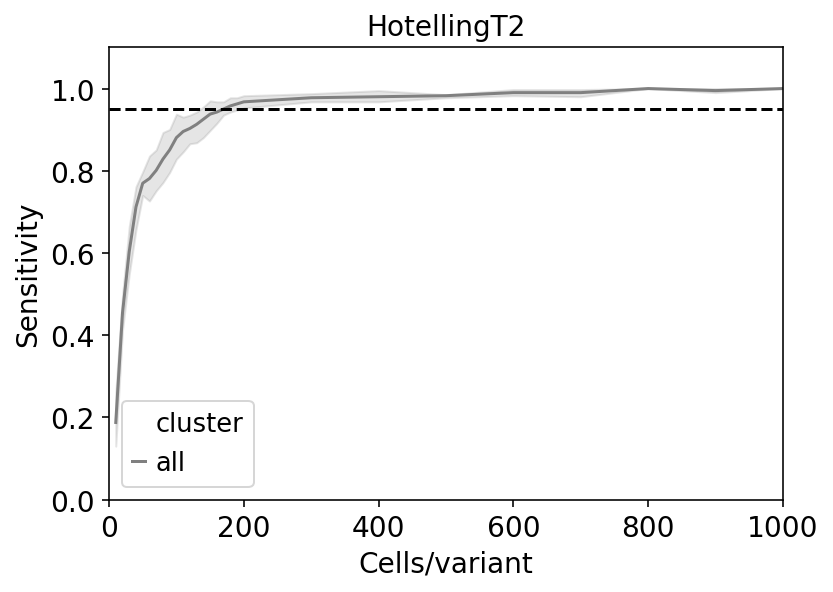

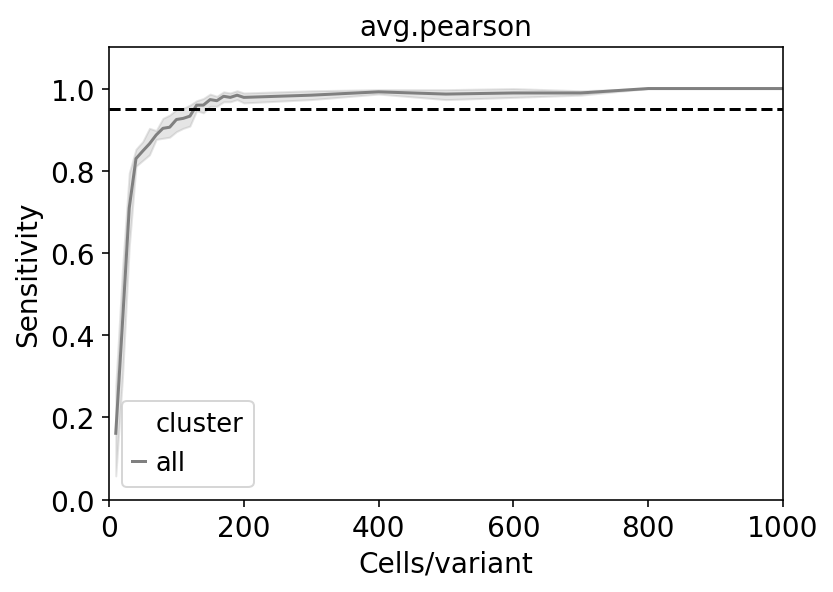

In [148]:
#how to make lines with error bars
method='HotellingT2'

palette={}
for i in ['#138D75', '#BB8FCE', 'black', 'gold', 'red']:
    palette[i]=i
palette['all']='gray'
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette=palette,
    ci=95,
)
plt.ylim(0,1.1)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette=palette,
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

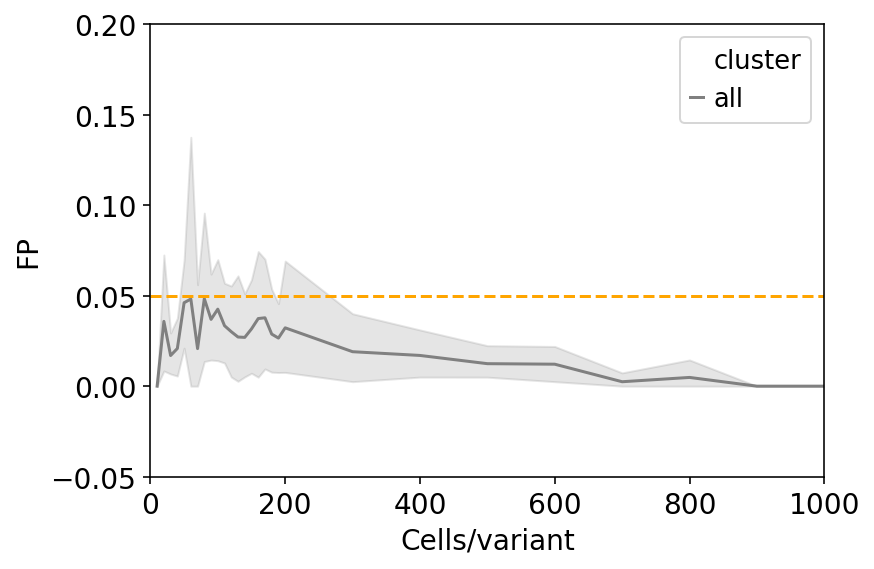

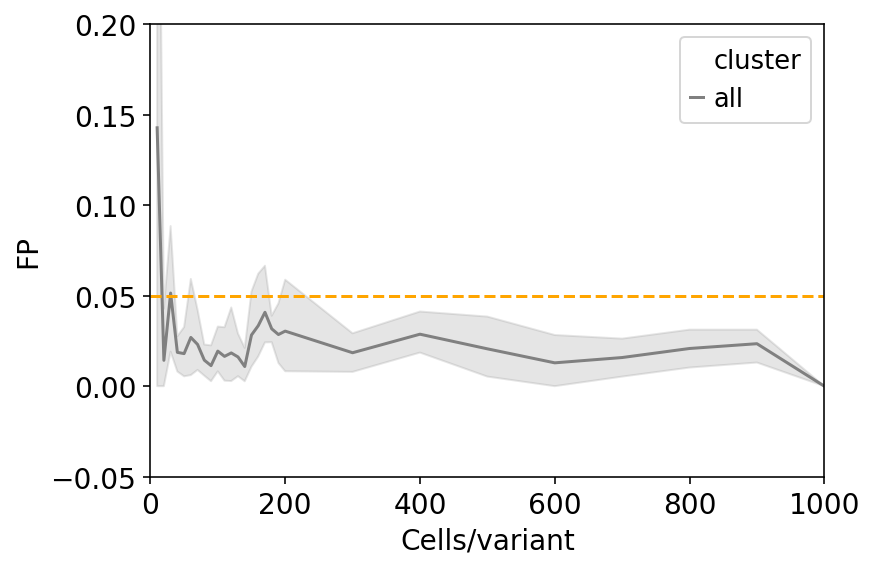

In [150]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
palette={}
for i in ['#138D75', '#BB8FCE', 'black', 'gold', 'red']:
    palette[i]=i
palette['all']='gray'
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette=palette,
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='orange',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette=palette,
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='orange',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [151]:
#make plots with confidence intervals for each subsampling
sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants.csv',header=None)
sorted_variants=list(sorted_variants_df[0])
print(sorted_variants)

['M111L', 'T127T', 'V112I', 'R149K', 'S17S', 'T74T', 'I163S', 'G75A', 'K147N', 'G77A', 'K88K', 'WT', 'A155G', 'Y166H', 'K176Q', 'T144T', 'C118S', 'T158T', 'A130V', 'D30D', 'K179R', 'S136N', 'T158A', 'T20T', 'D173D', 'V8V', 'A66A', 'M170L', 'K169K', 'T50T', 'R135T', 'F141L', 'R164Q', 'P110S', 'K178K', 'L159S', 'L79I', 'Q25H', 'K147T', 'E63K', 'V14I', 'T50I', 'T50P', 'E31K', 'Q99E', 'R41K', 'T20R', 'Q22H', 'C185Y', 'T20M', 'T144P', 'L52F', 'T74A', 'D57N', 'unassigned', 'N26Y', 'D33E', 'L19F', 'Q61K', 'P34L', 'K5E', 'P34R', 'G60D', 'Q61P', 'G60S', 'G60V', 'R68S', 'I36M', 'T58I', 'Q22K', 'K117R', 'A59T', 'AG59GV', 'D119G', 'G12Y', 'G12F', 'V14L', 'A59E', 'G12S', 'G12A', 'A59G', 'A146V', 'G13C', 'G12C', 'A146P', 'A146T', 'G12V', 'AG11TD', 'G12D', 'G12I', 'G12R', 'Q61A', 'Q61H', 'Q61R', 'Q61L', 'G13E', 'K117N', 'G13V', 'G13R']


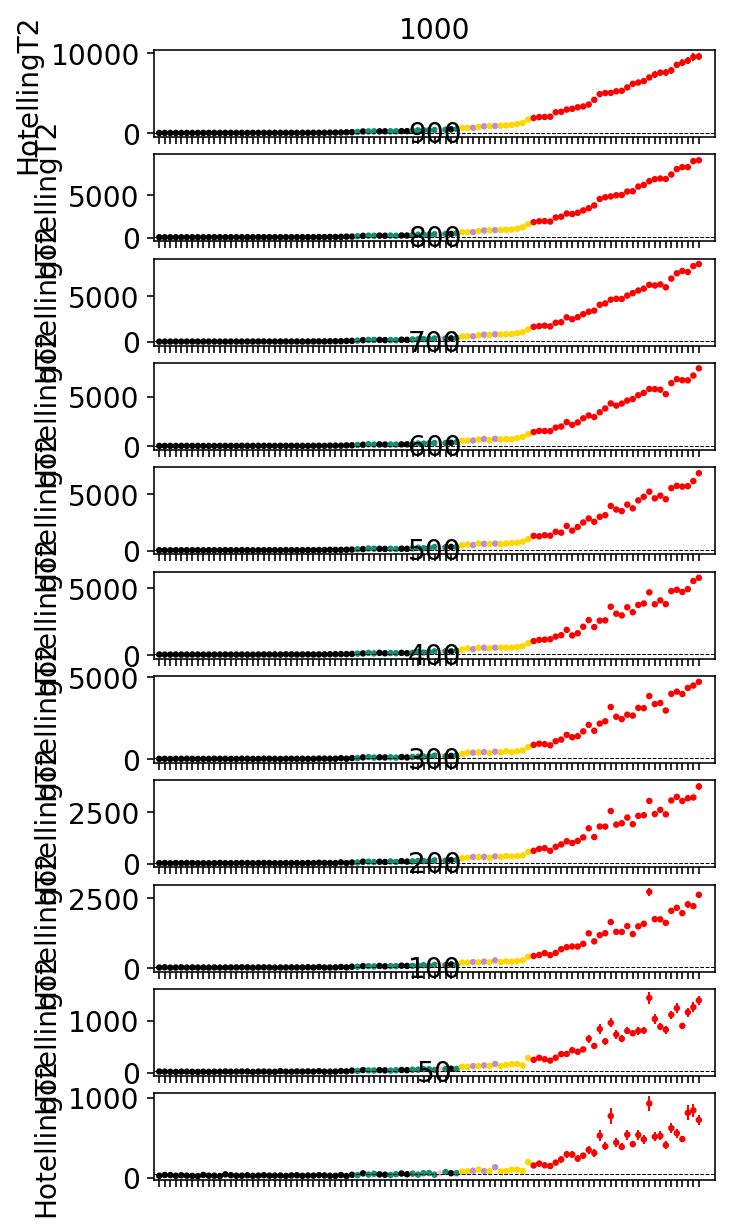

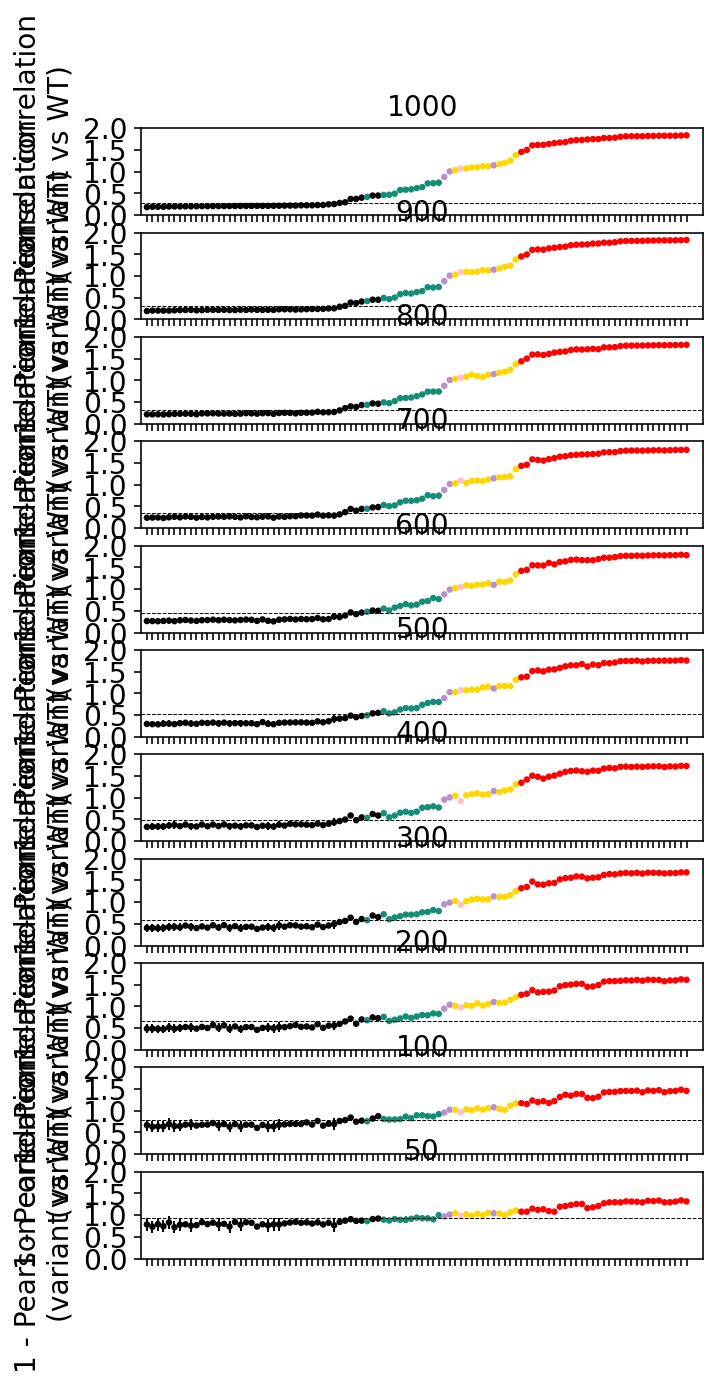

In [159]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,method,statname='.q',FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[method+statname]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)


subs_list=[1000,900,800,700,600,500,400,300,200,100,50]


methods=['HotellingT2','avg.pearson']
for method in methods:
    SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
    scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
    scores=pd.read_csv(scorefile,header=0,index_col=0)
    anno[method+'.ci.0.95.mean']=scores.loc[anno.index,method+'.ci.0.95.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.loc[variants,:]
    anno=anno.sort_values(by=[method+'.ci.0.95.mean'],ascending=True)

    fig,plots=plt.subplots(len(subs_list),1)
    fig.set_size_inches(5,10)
    c=0
    for subs in subs_list:

        SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
        scorefile=SCORE_DIR+'/scores.iter0.cells'+str(subs)+'.cells.csv'
        scores=pd.read_csv(scorefile,header=0,index_col=0)        

        w=10
        h=6
        
        plot_with_errorbars(list(anno.index),
                            scores.loc[anno.index,method+'.ci.0.95.mean'],
                           scores.loc[anno.index,method+'.ci.0.95.low'],
                           scores.loc[anno.index,method+'.ci.0.95.high'],
                            plots=plots[c],
                            flip_axes=False,
                            color_lines=list(anno.loc[anno.index,'cluster_color']),

                            s=5,
                           c=list(anno.loc[anno.index,'cluster_color']))

        if method=='avg.pearson':
            plots[c].set_ylabel('1 - Pearson correlation\n(variant vs WT)')
            plots[c].set_ylim(0,2)
            plots[c].set_yticks([0,0.5,1.0,1.5,2])
        if method=='HotellingT2':
            plots[c].set_ylabel('HotellingT2')
            #plots.set_ylim(0,1.5)
            #plots.set_yticks([0,0.5,1.0,1.5])
        plots[c].set_xticklabels([])
        plots[c].set_xlim(-1,101)

        #figure out FDR line
        thresh=get_threshold_at_FDR(scores,method,statname='.q')
        plots[c].axhline(y=thresh,color='black',linestyle='--',linewidth=0.5)
        plots[c].set_title(str(subs))
        c+=1
    plt.show()

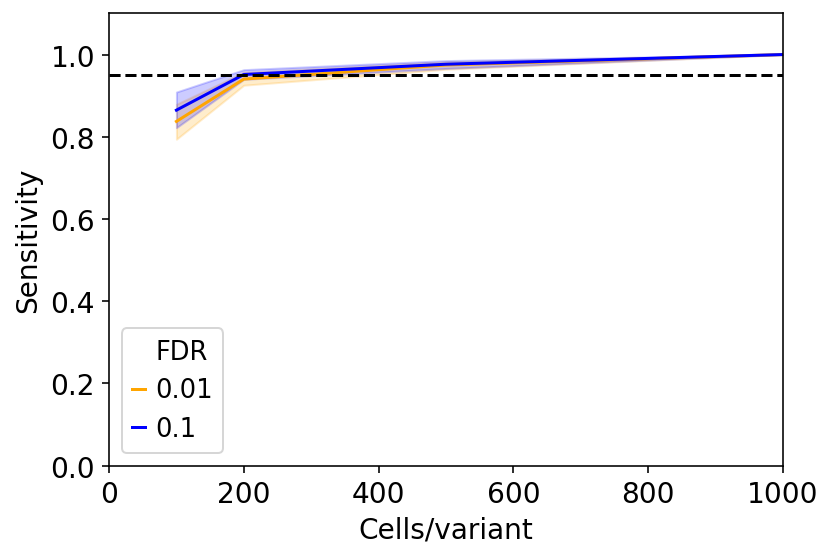

            cells    recall   FDR        FP
1000.0.01.0  1000  1.000000  0.01  0.000000
1000.0.1.0   1000  1.000000  0.10  0.000000
500.0.01.0    500  0.985075  0.01  0.000000
500.0.1.0     500  0.985294  0.10  0.028986
200.0.01.0    200  0.985075  0.01  0.014925
200.0.1.0     200  0.970588  0.10  0.043478
100.0.01.0    100  0.940299  0.01  0.059701
100.0.1.0     100  0.970588  0.10  0.108108
1000.0.01.1  1000  1.000000  0.01  0.000000
1000.0.1.1   1000  1.000000  0.10  0.000000
500.0.01.1    500  0.985075  0.01  0.014925
500.0.1.1     500  0.985294  0.10  0.014706
200.0.01.1    200  0.985075  0.01  0.014925
200.0.1.1     200  0.985294  0.10  0.129870
100.0.01.1    100  0.820896  0.01  0.067797
100.0.1.1     100  0.852941  0.10  0.079365
1000.0.01.2  1000  1.000000  0.01  0.000000
1000.0.1.2   1000  1.000000  0.10  0.000000
500.0.01.2    500  0.970149  0.01  0.029851
500.0.1.2     500  0.970588  0.10  0.029412
200.0.01.2    200  0.940299  0.01  0.015625
200.0.1.2     200  0.955882  0.1

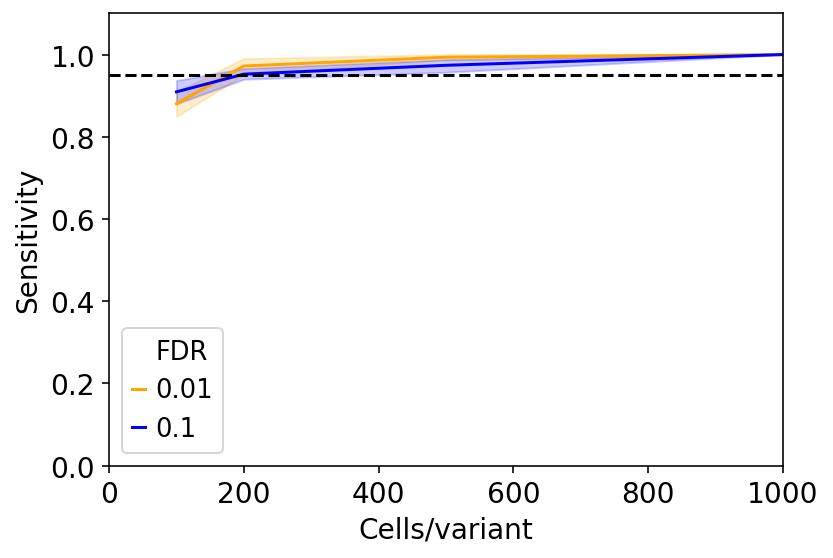

            cells    recall   FDR        FP
1000.0.01.0  1000  1.000000  0.01  0.000000
1000.0.1.0   1000  1.000000  0.10  0.000000
500.0.01.0    500  0.967213  0.01  0.000000
500.0.1.0     500  0.907692  0.10  0.000000
200.0.01.0    200  0.983607  0.01  0.000000
200.0.1.0     200  0.953846  0.10  0.000000
100.0.01.0    100  0.885246  0.01  0.000000
100.0.1.0     100  0.953846  0.10  0.031250
1000.0.01.1  1000  1.000000  0.01  0.000000
1000.0.1.1   1000  1.000000  0.10  0.000000
500.0.01.1    500  1.000000  0.01  0.061538
500.0.1.1     500  1.000000  0.10  0.015152
200.0.01.1    200  1.000000  0.01  0.115942
200.0.1.1     200  1.000000  0.10  0.133333
100.0.01.1    100  0.901639  0.01  0.035088
100.0.1.1     100  0.969231  0.10  0.030769
1000.0.01.2  1000  1.000000  0.01  0.000000
1000.0.1.2   1000  1.000000  0.10  0.000000
500.0.01.2    500  1.000000  0.01  0.016129
500.0.1.2     500  1.000000  0.10  0.000000
200.0.01.2    200  1.000000  0.01  0.000000
200.0.1.2     200  0.938462  0.1

In [37]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method], x="cells", y="recall",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(0,1.1)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

print(res[method])


#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method], x="cells", y="recall",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

print(res[method])

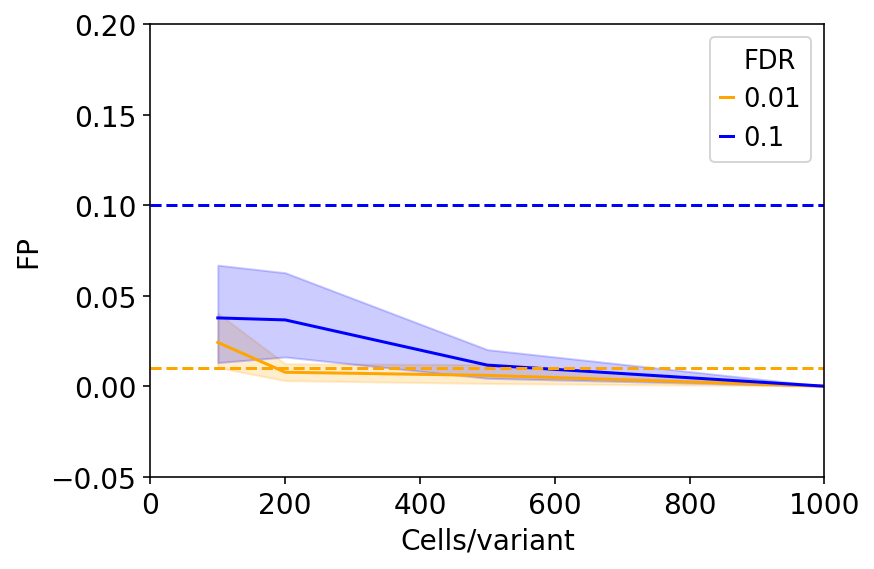

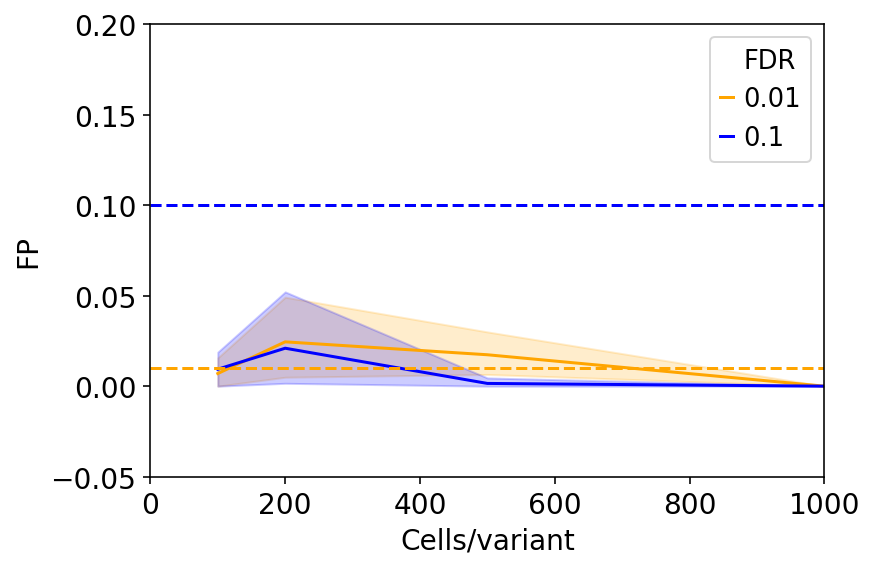

In [38]:
method='HotellingT2'

sns.lineplot(
    data=res[method], x="cells", y="FP",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=0.1,color='blue',linestyle='--')
plt.axhline(y=0.01,color='orange',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()


method='avg.pearson'

sns.lineplot(
    data=res[method], x="cells", y="FP",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.1,color='blue',linestyle='--')
plt.axhline(y=0.01,color='orange',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [116]:
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter1.cells100.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)
anno=anno.loc[variants,:]

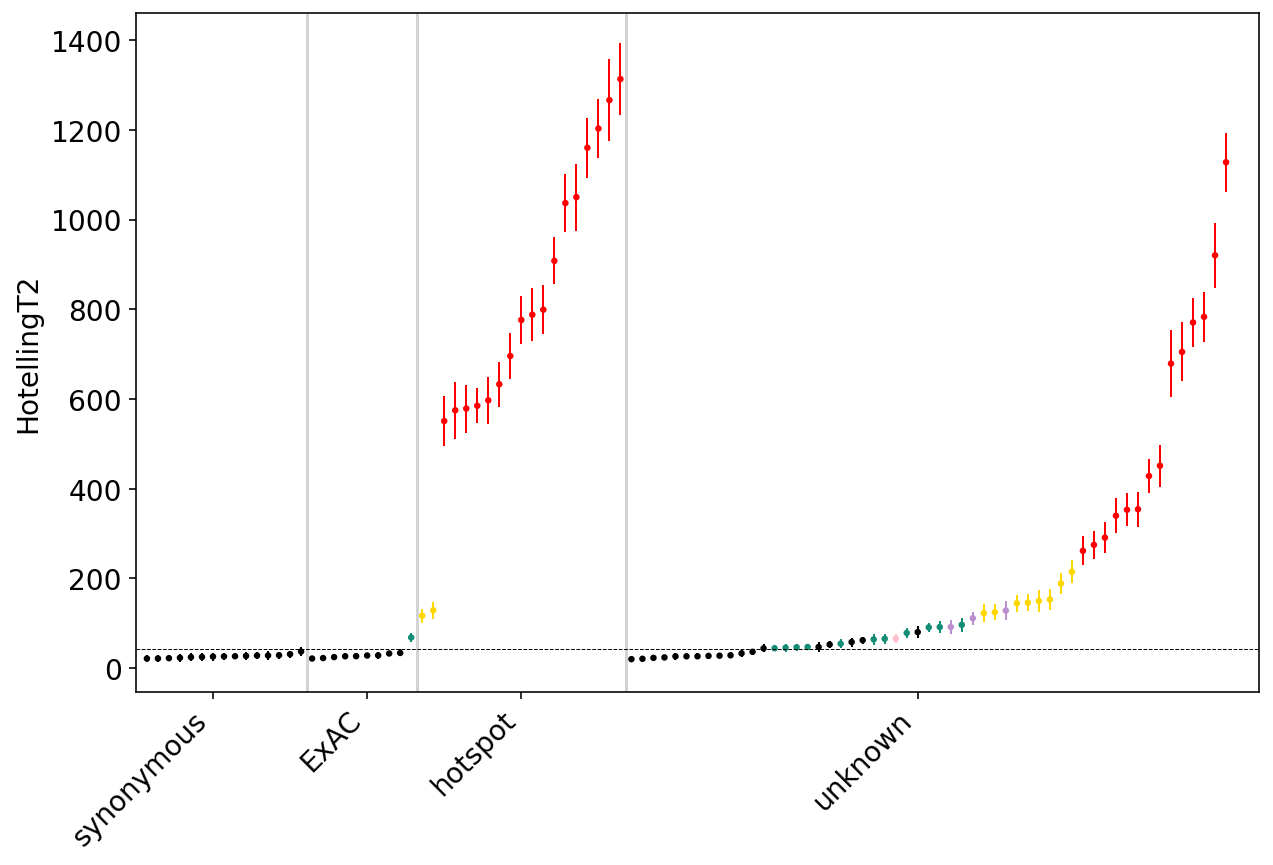

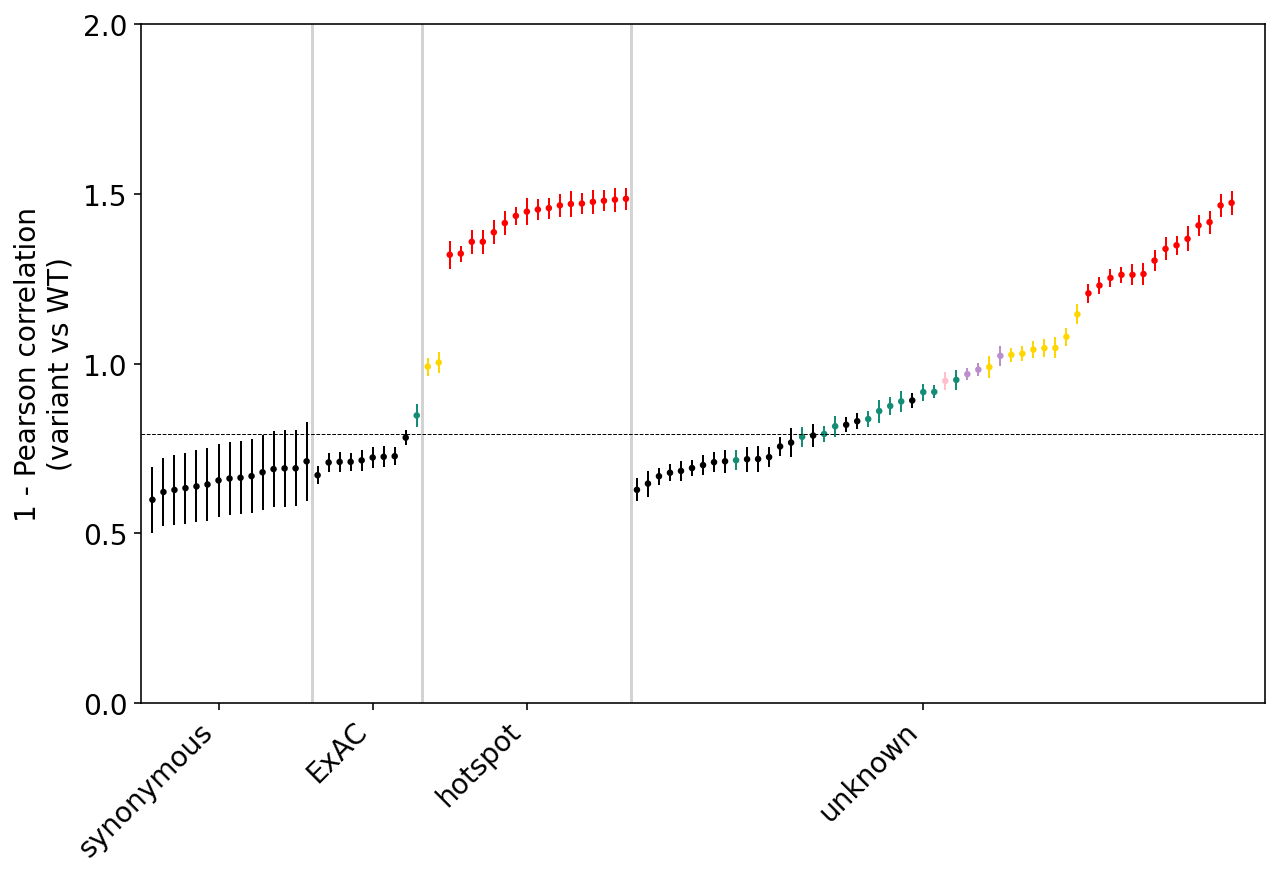

In [117]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,method,statname='.q',FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[method+statname]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)
    
methods=['HotellingT2','avg.pearson']
for method in methods:
    anno[method+'.ci.0.95.mean']=scores.loc[anno.index,method+'.ci.0.95.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.loc[variants,:]
    anno=anno.sort_values(by=['control_status2',method+'.ci.0.95.mean'],ascending=True)

    w=10
    h=6
    fig,plots=plt.subplots(1)
    fig.set_size_inches(w,h)
    plot_with_errorbars(list(anno.index),
                        scores.loc[anno.index,method+'.ci.0.95.mean'],
                       scores.loc[anno.index,method+'.ci.0.95.low'],
                       scores.loc[anno.index,method+'.ci.0.95.high'],
                        plots=plots,
                        flip_axes=False,
                        color_lines=list(anno.loc[anno.index,'cluster_color']),

                        s=5,
                       c=list(anno.loc[anno.index,'cluster_color']))
    plots.axvline(x=14.5,color='lightgray')
    plots.axvline(x=24.5,color='lightgray')
    plots.axvline(x=43.5,color='lightgray')
    if method=='avg.pearson':
        plots.set_ylabel('1 - Pearson correlation\n(variant vs WT)')
        plots.set_ylim(0,2)
        plots.set_yticks([0,0.5,1.0,1.5,2])
    if method=='HotellingT2':
        plots.set_ylabel('HotellingT2')
        #plots.set_ylim(0,1.5)
        #plots.set_yticks([0,0.5,1.0,1.5])
    plots.set_xticklabels([])
    plots.set_xlim(-1,101)
    plots.set_xticks([6,20,34,70])
    plots.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,
                         ha='right')

    #figure out FDR line
    thresh=get_threshold_at_FDR(scores,method,statname='.q')
    plt.axhline(y=thresh,color='black',linestyle='--',linewidth=0.5)
    plt.show()